In [67]:
import os
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt

In [68]:
print(f"Is CUDA available: {torch.cuda.is_available()}")
print(f"PyTorch Version: {torch.__version__}")

Is CUDA available: True
PyTorch Version: 1.10.0+cu113


In [69]:
dataset_path = os.path.abspath("dataset")

transforms = tt.Compose([tt.Resize((256, 256)),
                        tt.ToTensor(),
                        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = ImageFolder(os.path.join(dataset_path, "Train"), transforms)
test_dataset = ImageFolder(os.path.join(dataset_path, "Test"), transforms)
validation_dataset = ImageFolder(os.path.join(dataset_path, "Validation"), transforms)

In [70]:
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, num_workers=0)

In [71]:
label_map = {0: "mask", 1: "no_mask"}

def show_batch(dataloader):
    for images, labels in dataloader:
        fig, axs = plt.subplots(4, int(batch_size/4), constrained_layout=True, dpi=300)

        for (image, label, axs) in zip(images, labels, axs.flatten()):
            axs.imshow(image.permute(1,2,0).clamp(0,1))
            axs.set_title(label_map[label.item()])
            axs.axis('off')
        
        break

    plt.show()

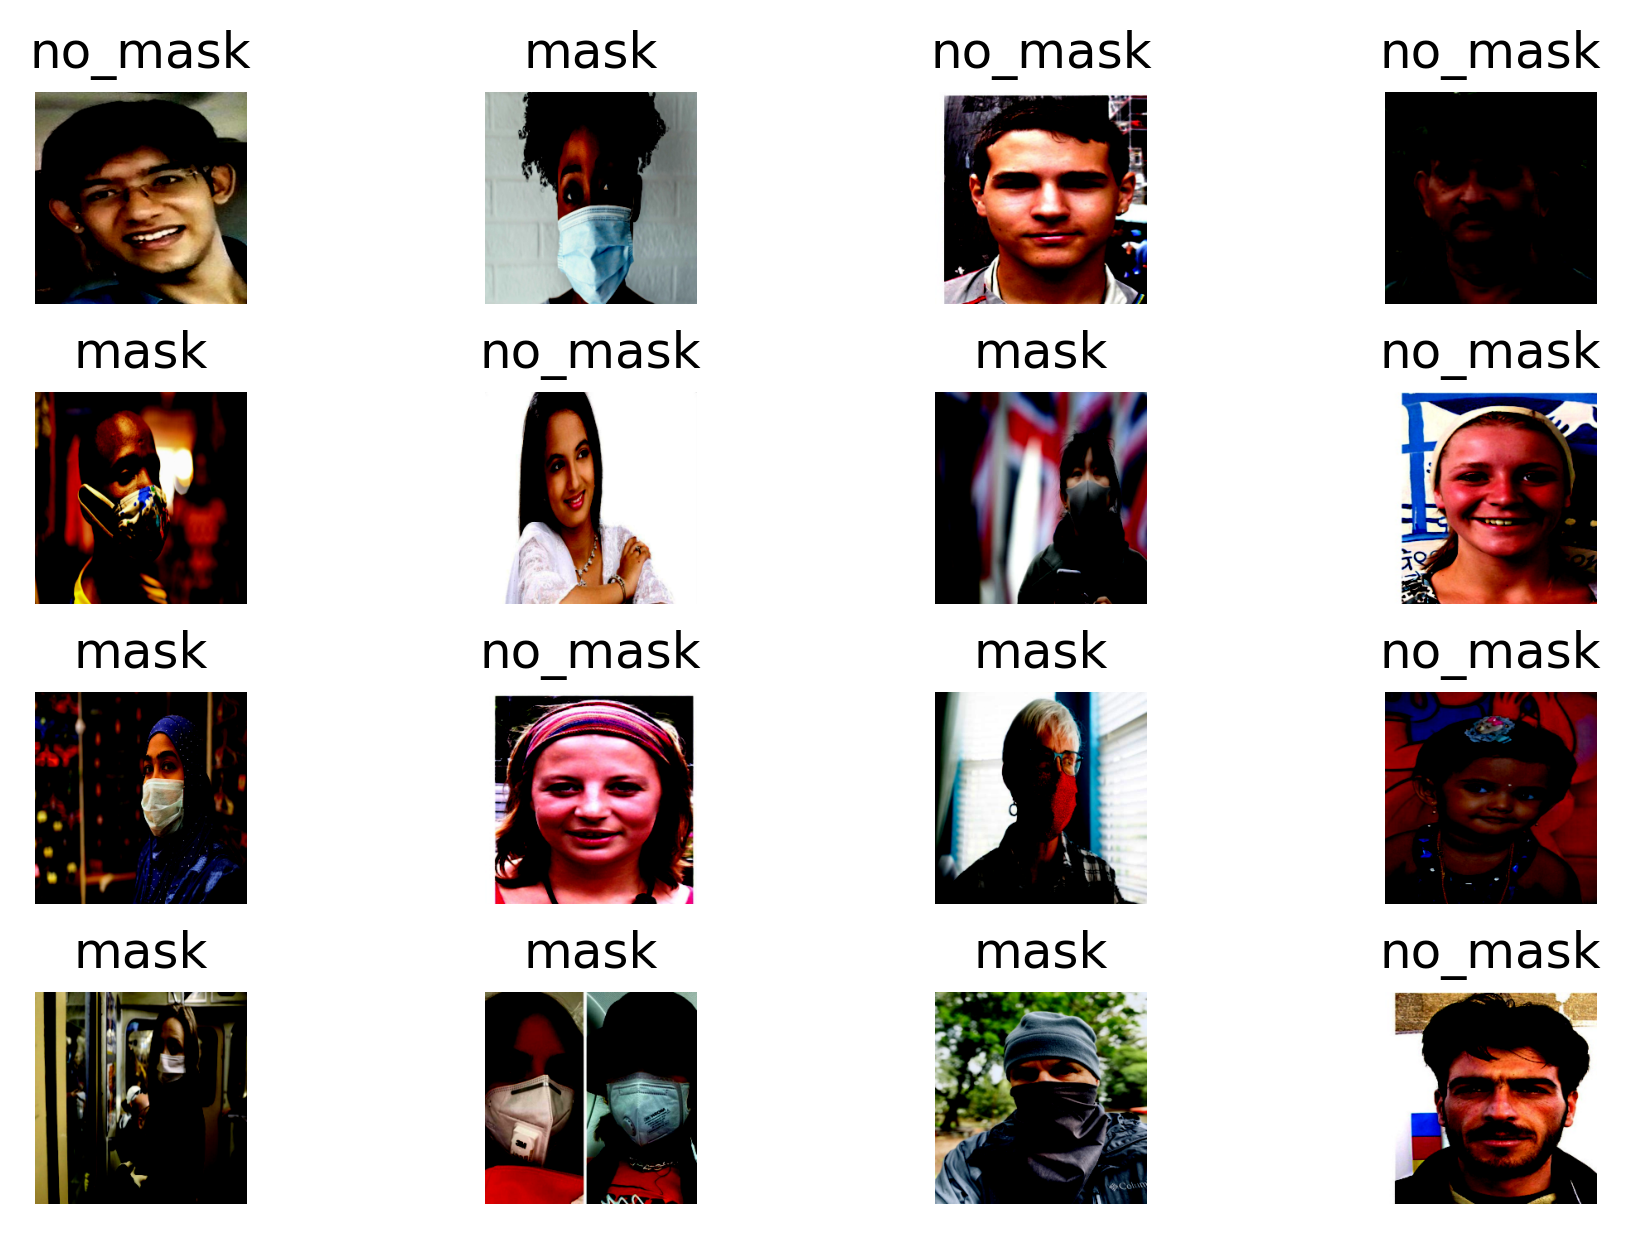

In [72]:
show_batch(train_dataloader)

In [73]:
for images, labels in test_dataloader:
    print(f"Shape of images [N, C, H, W]: {images.shape}")
    print(f"Shape of labels: {labels.shape}, {labels.dtype}")
    break

Shape of images [N, C, H, W]: torch.Size([16, 3, 256, 256])
Shape of labels: torch.Size([16]), torch.int64


In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [75]:
from cnn_model import mask_net

model = mask_net(in_channels=3, num_classes=2).to(device)
print(model)

mask_net(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [76]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [77]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [78]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [79]:
epochs = 50

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 0.658225  [    0/  600]
loss: 0.318676  [  160/  600]
loss: 0.510028  [  320/  600]
loss: 0.543297  [  480/  600]
Test Error: 
 Accuracy: 69.0%, Avg loss: 0.594127 

Epoch 2
-------------------------------
loss: 0.295378  [    0/  600]
loss: 0.195071  [  160/  600]
loss: 0.098420  [  320/  600]
loss: 0.128417  [  480/  600]
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.199922 

Epoch 3
-------------------------------
loss: 0.036847  [    0/  600]
loss: 0.017385  [  160/  600]
loss: 0.045730  [  320/  600]
loss: 0.029663  [  480/  600]
Test Error: 
 Accuracy: 69.0%, Avg loss: 0.709252 

Epoch 4
-------------------------------
loss: 0.035599  [    0/  600]
loss: 0.014662  [  160/  600]
loss: 0.013916  [  320/  600]
loss: 0.009109  [  480/  600]
Test Error: 
 Accuracy: 89.0%, Avg loss: 0.200462 

Epoch 5
-------------------------------
loss: 0.004384  [    0/  600]
loss: 0.005443  [  160/  600]
loss: 0.035753  [  320/  600]
loss: 0.016703  [  480

In [82]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
torch.save(model.state_dict(), "model.pth")
print("Saved net model state to model.pth")

Saved net model state to model.pth


In [83]:
model = mask_net(in_channels=3, num_classes=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.load_state_dict(torch.load("model.pth", map_location=device))

<All keys matched successfully>

In [84]:
def predict(tensor, model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    tensor = tensor.to(device)
    prediction = model(tensor.unsqueeze(0))
    prediction = prediction.clone().detach()
    return prediction

In [85]:
classes = ["mask", "no_mask"]

model.eval()

rand_number = random.randint(0, len(validation_dataset))
x, y = validation_dataset[rand_number][0], validation_dataset[rand_number][1]

with torch.no_grad():
    pred = predict(x, model)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f"Predicted: \"{predicted}\", Actual: \"{actual}\"")

Predicted: "mask", Actual: "mask"


In [86]:
classes = ["mask", "no_mask"]

def show_validation(images, labels):
    fig, axs = plt.subplots(4, int(batch_size/4), constrained_layout=True, dpi=300)
    
    for (image, label, axs) in zip(images, labels, axs.flatten()):
        axs.imshow(image.permute(1,2,0).clamp(0,1))
        
        with torch.no_grad():
            pred = predict(image, model)
            predicted, actual = classes[pred[0].argmax(0)], classes[label]
            axs.set_title(f"net:{predicted},\nirl: {actual}", fontsize=10)
        
        axs.axis('off')

    plt.show()

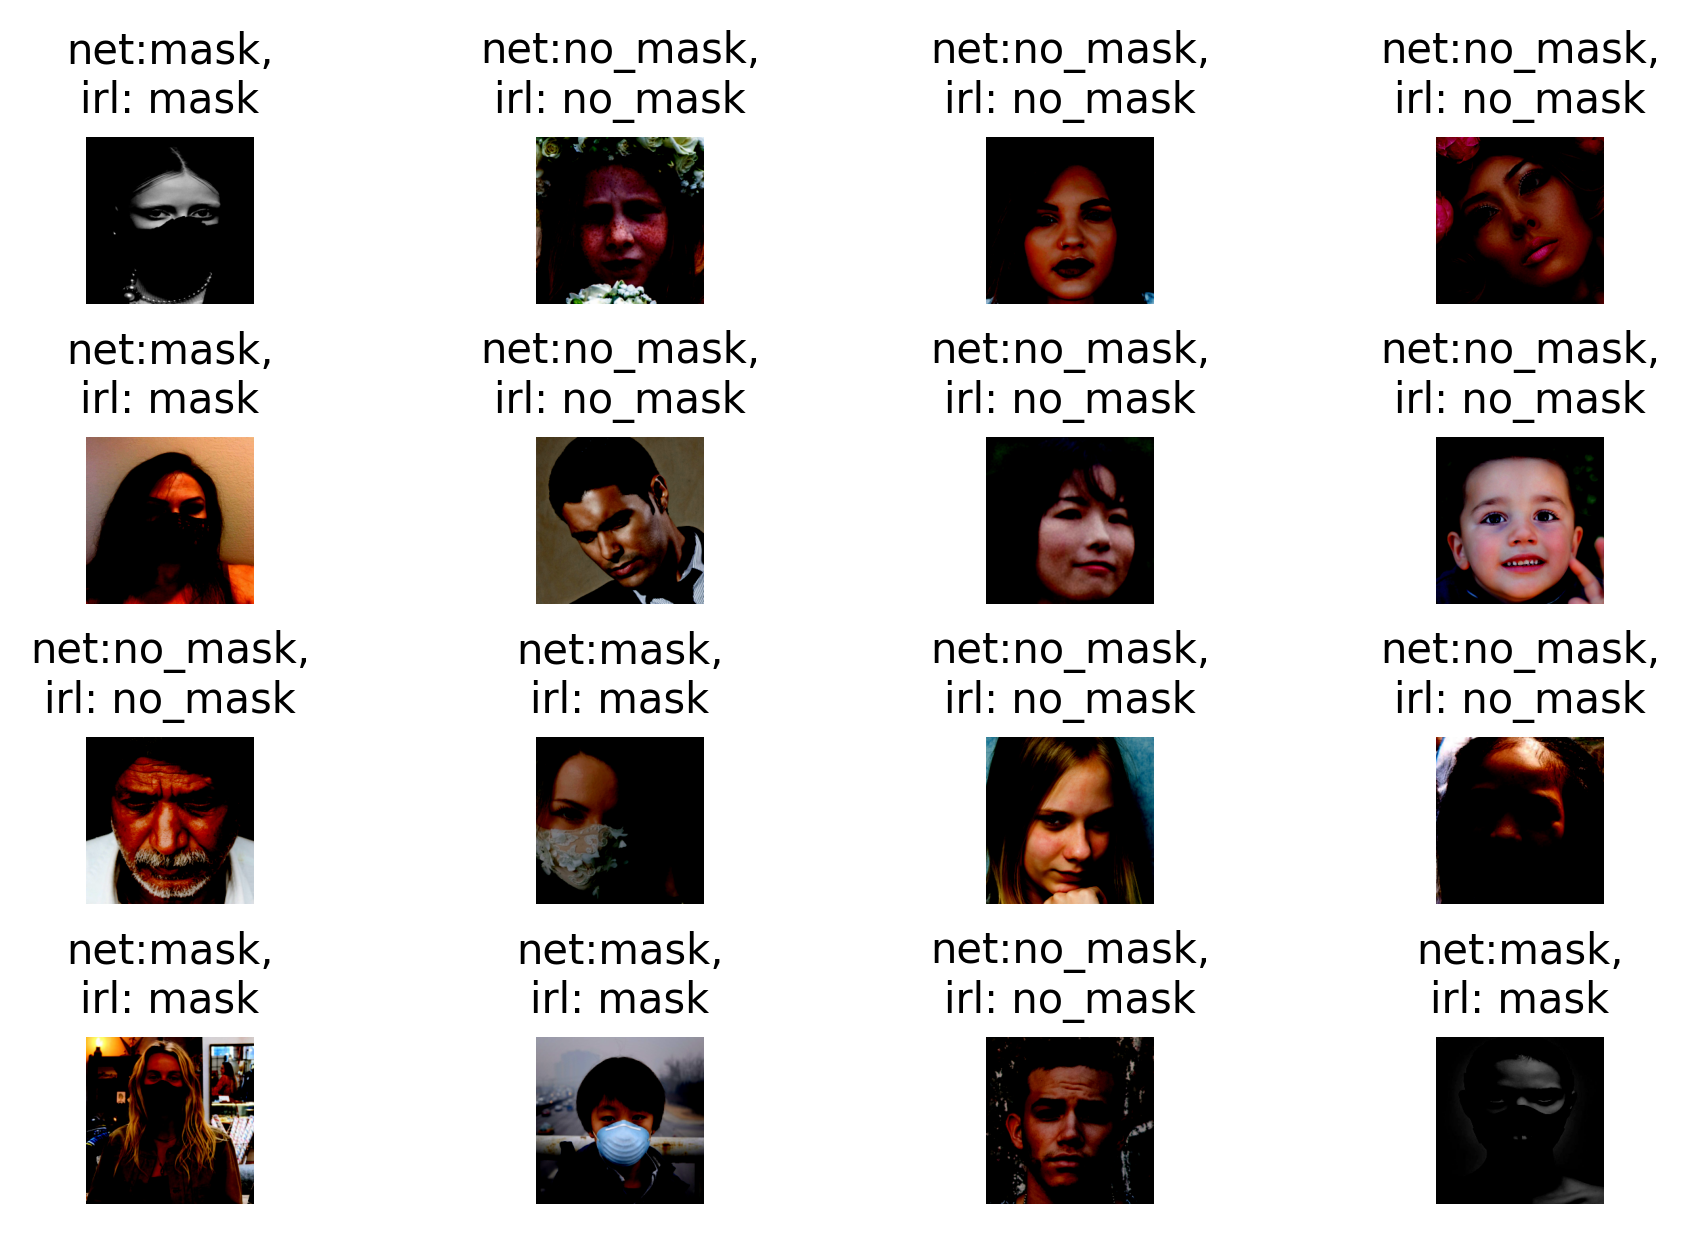

In [91]:
random_nums = [random.randint(0, len(validation_dataset) - 1) for _ in range(batch_size)]
imgs = [validation_dataset[i][0] for i in random_nums]
labls = [validation_dataset[i][1] for i in random_nums]

show_validation(imgs, labls)